<h1>Predicting Solubility Using AMPL</h1>

The ATOM Modeling PipeLine (AMPL; https://github.com/ATOMScience-org/AMPL) is an open-source, modular, extensible software pipeline for building and sharing models to advance in silico drug discovery.


## Notebook execution time: ~ 3 minutes

In [6]:
!date

Mon Feb 26 23:50:48 UTC 2024


In [7]:
%ls -lr

total 740
-rw-r--r-- 1 sagemaker-user users    179 Feb 26 23:29 install_AMPL_GPU_test.sh.1
-rwxr--r-- 1 sagemaker-user users    179 Feb 26 21:33 install_AMPL_GPU_test.sh*
drwxr-xr-x 5 sagemaker-user users     53 Feb 26 21:33 github/
-rw-r--r-- 1 sagemaker-user users 195081 Feb 26 21:40 delaney_curated.csv
-rw-r--r-- 1 sagemaker-user users     21 Feb 26 21:18 README.md
-rw-r--r-- 1 sagemaker-user users   1066 Feb 26 21:18 LICENSE
-rw-r--r-- 1 sagemaker-user users 542144 Feb 26 23:50 10_Delaney_Solubility_Prediction_AWS.ipynb


# Goal: Predict solubility using the ATOM Modeling Pipeline (AMPL) on the public dataset

In this notebook, we describe the following steps using AMPL:

1.   Read a public dataset containing chemical structures and some properties
1.   Curate the dataset
2.   Fit a simple model
3.   Predict solubility for withheld compounds


## Set up
We first import the AMPL modules for use in this notebook.

The relevant AMPL modules for this example are listed below:

|module|Description|
|-|-|
|`atomsci.ddm.pipeline.model_pipeline`|The model pipeline module is used to fit models and load models for prediction.|
|`atomsci.ddm.pipeline.parameter_parser`|The parameter parser reads through pipeline options for the model pipeline.|
|`atomsci.ddm.utils.curate_data`|The curate data module is used for data loading and pre-processing.|
|`atomsci.ddm.utils.struct_utils`|The structure utilities module is used to process loaded structures.|
|`atomsci.ddm.pipeline.perf_plots`|Perf plots contains a variety of plotting functions.|

## Install AMPL

In [8]:
! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

  Using cached rdkit_pypi-2022.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
Using cached rdkit_pypi-2022.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.4 MB)
  Using cached deepchem-2.7.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached scipy-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
  Using cached rdkit-2023.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached deepchem-2.7.1-py3-none-any.whl (693 kB)
Using cached scipy-1.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.2 MB)
Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached rdkit-2023.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Attempting uninstall: numpy
    Found existing installation: nu

2024-02-26 23:51:20.401893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/conda/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


  Using cached umap-0.1.1-py3-none-any.whl
  Using cached numba-0.59.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numba-0.59.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
Using cached llvmlite-0.42.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.8 MB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.4 which is incompatible.
jax 0.4.20 requires scipy>=1.9, but you have scipy 1.8.1 which is incompat

In [9]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
! wget 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh' >& /dev/null

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'AMPL' already exists and is not an empty directory.
Already on 'master'
Your branch is up to date with 'origin/master'.
/opt/conda/lib/python3.10/site-packages/setuptools/dist.py:674: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprecated.
!!

        ********************************************************************************
        Please replace its usage with implicit namespaces (PEP 420).

        See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages for details.
        ********************************************************************************

!!
  ep.load()(self, ep.name, value)
running build
running build_py
copying atomsci/__init__.py -> /home/sagemaker-user/BigDataSys-Project8/github/AMPL.build/ampl/lib/atomsci
copying atomsci/ddm/__init__.py -> /home/sagemaker-user/BigDataSys-Project8/github/AMPL.build/ampl/lib/atomsci/ddm
cop

In [10]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import os
import requests
import sys

import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp


In [12]:
import os

# Specify the path to the directory
path_to_directory = '/home/sagemaker-user/BigDataSys-Project8'

# Change the current working directory
os.chdir(path_to_directory)

# Now import the atomsci.ddm module
import atomsci.ddm.pipeline.model_pipeline as mp

In [13]:
# Import DeepChem
import deepchem as dc

# Use these commands in a cell of your Jupyter notebook or in your shell

# Download the installation script for AMPL
!wget 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh'

# Make the script executable
!chmod u+x install_AMPL_GPU_test.sh

# Execute the script
!./install_AMPL_GPU_test.sh

--2024-02-26 23:52:34--  https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
ERROR: cannot verify raw.githubusercontent.com's certificate, issued by ‘CN=DigiCert TLS RSA SHA256 2020 CA1,O=DigiCert Inc,C=US’:
  Unable to locally verify the issuer's authority.
To connect to raw.githubusercontent.com insecurely, use `--no-check-certificate'.


mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'AMPL' already exists and is not an empty directory.
Already on 'master'
Your branch is up to date with 'origin/master'.
/opt/conda/lib/python3.10/site-packages/setuptools/dist.py:674: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprecated.
!!

        ********************************************************************************
        Please replace its usage with implicit namespaces (PEP 420).

        See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages for details.
        ********************************************************************************

!!
  ep.load()(self, ep.name, value)
running build
running build_py
copying atomsci/__init__.py -> /home/sagemaker-user/BigDataSys-Project8/github/AMPL.build/ampl/lib/atomsci
copying atomsci/ddm/__init__.py -> /home/sagemaker-user/BigDataSys-Project8/github/AMPL.build/ampl/lib/atomsci/ddm
cop

In [14]:
!wget --no-check-certificate 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh'

# Make the script executable (only if the download was successful)
!chmod u+x install_AMPL_GPU_test.sh

# Execute the script (only if the file exists)
!./install_AMPL_GPU_test.sh

--2024-02-26 23:52:36--  https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 179 [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh.2’

install_AMPL_GPU_te 100%[===================>]     179  --.-KB/s    in 0s      

2024-02-26 23:52:36 (3.58 MB/s) - ‘install_AMPL_GPU_test.sh.2’ saved [179/179]

mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'AMPL' already exists and is not an empty directory.
Already on 'master'
Your branch is up to date with 'origin/master'.
/opt/conda/lib/python3.10/site-packages/setuptools/dist.py:674: SetuptoolsDeprecationWarning: The name

## Data curation

We then download and do very simple curation to the related dataset.

We need to set the directory we want to save files to. Next we download the dataset.

In [15]:
pwd

'/home/sagemaker-user/BigDataSys-Project8'

In [16]:
working_dir = '/home/sagemaker-user/BigDataSys-Project8'

In [17]:
import io
url = 'https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv'
download = requests.get(url).content

In [18]:
# Reading the downloaded content and turning it into a pandas dataframe
raw_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

Next, we load the downloaded dataset, and process the compound structures:

In [19]:
data_orig = raw_df

In [20]:
raw_df.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')

In [21]:
raw_df.head(5)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [22]:
# base_smiles_from_smiles:
# Generate a standardized SMILES, InChI keys for dataset with curation and structure modules.
# RDkit modules are used to process the SMILES strings

# Default Arg options:
# useIsomericSmiles = True
# removeCharges = False

raw_df['rdkit_smiles'] = raw_df['smiles'].apply(curate_data.base_smiles_from_smiles)

## What happened after calling `base_smiles_from_smiles`?
Also remember the column name of the `rdkit_smiles`, we will use the standardized smiles later as input in our model calculations

In [23]:
raw_df.head(4)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21


## In the following cell, we will call smiles_to_inchi_key to create InChi Keys  

We will create InChi key (https://en.wikipedia.org/wiki/International_Chemical_Identifier) from SMILES string using RDKit. Note if for some reason, the convertion fails, you will see None as output

In [24]:
raw_df['inchi_key'] = raw_df['smiles'].apply(struct_utils.smiles_to_inchi_key)

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Charges were rearranged

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Charges were rearranged

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Charges were rearranged

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Charges were rearranged; Omitted undefined stereo

[23:52:40] WARNING: Charges were rearranged

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WARNING: Omitted undefined stereo

[23:52:40] WA

## Note the addition of new column, inchi_key

In [25]:
raw_df.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N


In [26]:
data = raw_df
data['compound_id'] = data['inchi_key']

## Let us review the dataset

In [27]:
data.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N


## Let us view some molecules

In [28]:
data['smiles'][0:10]

0    OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1                               Cc1occc1C(=O)Nc2ccccc2
2                                 CC(C)=CCCC(C)=CC(=O)
3                   c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4                                              c1ccsc1
5                                       c2ccc1scnc1c2 
6                   Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl
7                     CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O
8       ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
9     COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C 
Name: smiles, dtype: object

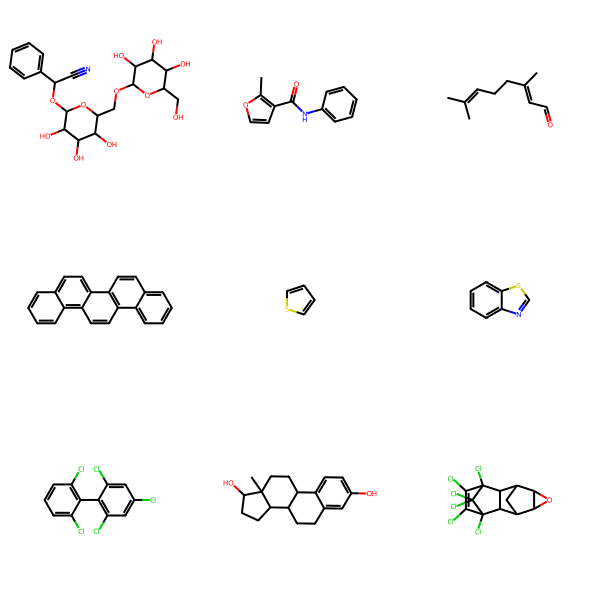

In [29]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice

molecules = [Chem.MolFromSmiles(smiles) for smiles in islice(data['smiles'], 9)]

Draw.MolsToGridImage(molecules)

The next step is to address the case where we have multiple measurements for a single structure (by RDkit canonical SMILEs string). We have a function in the `curate_data()` module to address the processing of compounds. The function parameters are listed below along with an explanation of each parameter:

In [30]:
data

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,GBROPGWFBFCKAG-UHFFFAOYSA-N,GBROPGWFBFCKAG-UHFFFAOYSA-N
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,c1ccsc1,YTPLMLYBLZKORZ-UHFFFAOYSA-N,YTPLMLYBLZKORZ-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,FC(F)(F)C(Cl)Br,BCQZXOMGPXTTIC-UHFFFAOYSA-N,BCQZXOMGPXTTIC-UHFFFAOYSA-N
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,CNC(=O)ON=C(SC)C(=O)N(C)C,KZAUOCCYDRDERY-UHFFFAOYSA-N,KZAUOCCYDRDERY-UHFFFAOYSA-N
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,CCSCCSP(=S)(OC)OC,OPASCBHCTNRLRM-UHFFFAOYSA-N,OPASCBHCTNRLRM-UHFFFAOYSA-N
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,CCC(C)C,QWTDNUCVQCZILF-UHFFFAOYSA-N,QWTDNUCVQCZILF-UHFFFAOYSA-N


In [31]:
# del_features = ['VALUE_NUM_mean', 'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate']
# data.drop(labels=del_features, axis=1, inplace=True)

In [32]:
# column: Response values column
column = 'measured log solubility in mols per litre'

# tolerance: Percentage of individual respsonse values allowed to be different
# from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# call the method `average_and_remove_duplicates` which changes the data and returns
# the new object as curated_df, in this case


curated_df = curate_data.average_and_remove_duplicates(column,
                                                       tolerance,
                                                       list_bad_duplicates,
                                                       data,
                                                       max_std,
                                                       compound_id=compound_id,
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (1126, 17)
List of 'bad' duplicates removed
                     compound_id  measured log solubility in mols per litre  \
233  FBPFZTCFMRRESA-UHFFFAOYSA-N                                       0.06   
276  FBPFZTCFMRRESA-UHFFFAOYSA-N                                       1.09   

     VALUE_NUM_mean   Perc_Var  VALUE_NUM_std  
233           0.575  89.565217        0.72832  
276           0.575  89.565217        0.72832  

Dataset de-duplicated
Dataframe size (1116, 17)
New column created with averaged values:  VALUE_NUM_mean


In [33]:
data.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N


In [34]:
curated_df.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N,-0.77,NaN,-0.0,0
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N,-3.30,NaN,-0.0,0
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N,-2.06,NaN,-0.0,0


In [35]:
import os
folder_name = 'BigDataSys-Project8'
curated_file = os.path.join('/home/sagemaker-user/BigDataSys-Project8', 'delaney_curated.csv')
curated_df.to_csv(curated_file, index=False)

Now that we have a curated dataset, we decide what type of featurizer and model we would like. See documentation for all available options. We also set the name of the new averaged response value column.

In [36]:
featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']

Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [37]:
smiles_col

'rdkit_smiles'

In [38]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

In [39]:
pparams = parse.wrapper(params)

## Details of the following code chunk
 Here we create instances of the class ModelPipeline, called `MP`. The instance `MP` has access to data attributes and methods of the class.

In [40]:
MP = mp.ModelPipeline(pparams)

## Use `dir` function to explore data attributes and functions associated with the class.

The output is a list of data object attributes. Note the attributes that are surrounded by double-underscore (ex., `__le__`) are for internal use
and you dont have to worry about them. The regular (non underscore attributes) are of your concern. In the example shown below, these attributes start
with `'create_model_metadata'`

In [41]:
dir(MP)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calc_train_dset_pair_dis',
 'create_model_metadata',
 'create_prediction_metadata',
 'ds_client',
 'get_metrics',
 'load_featurize_data',
 'log',
 'metric_type',
 'output_dir',
 'params',
 'perf_dict',
 'predict_embedding',
 'predict_full_dataset',
 'predict_on_dataframe',
 'predict_on_smiles',
 'run_mode',
 'run_predictions',
 'save_metrics',
 'save_model_metadata',
 'split_dataset',
 'start_time',
 'train_model']

### Train_model:
Build model described by self.params on the training dataset described by self.params.Generate predictions for the training, validation, and test datasets, and save the predictions and performance metrics in the model results DB or in a JSON file.

## Note `train_model` is a method of class `ModelPipeline`. If you are using COLAB, mouse-over the `MP.train_model()` to view the source code

In [42]:
import atomsci.ddm.pipeline.model_pipeline as mp
#mp.ampl_version

In [43]:
MP.train_model()

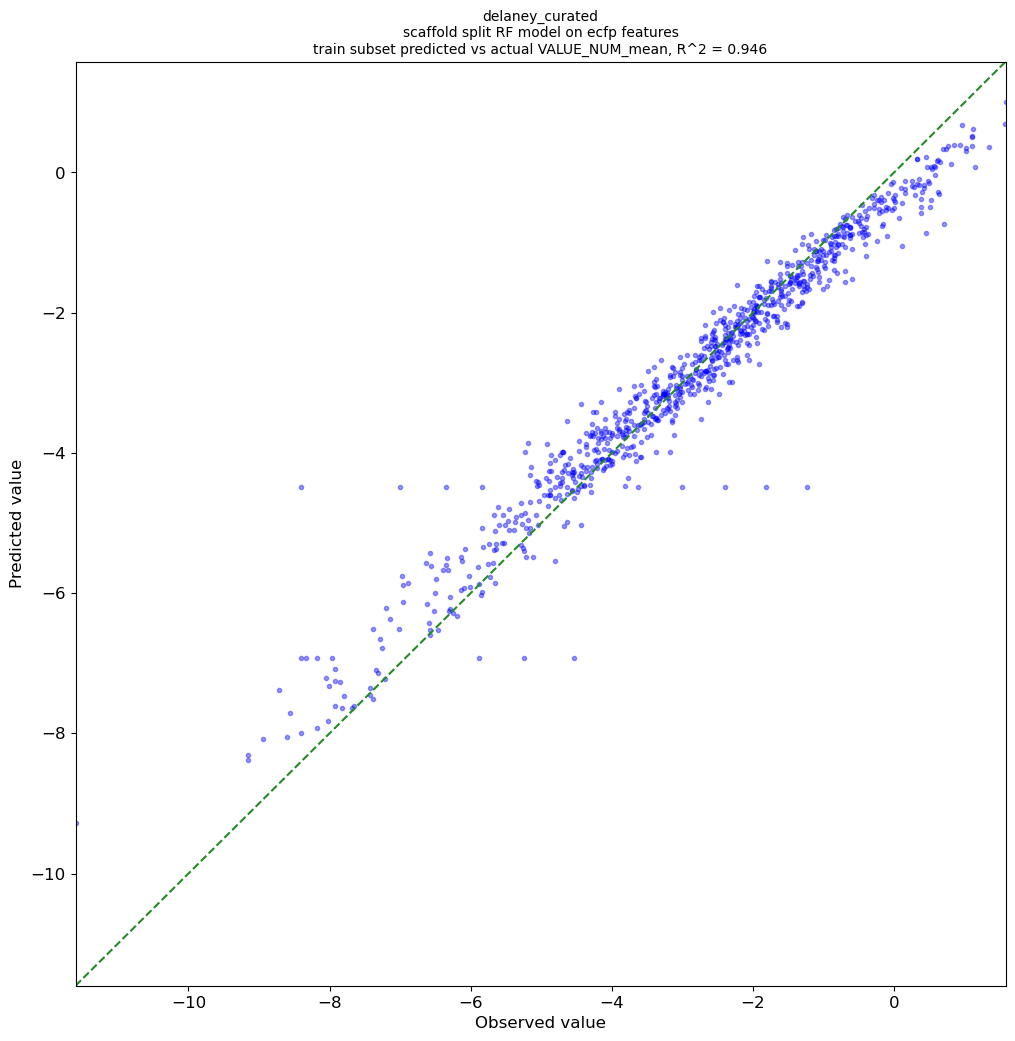

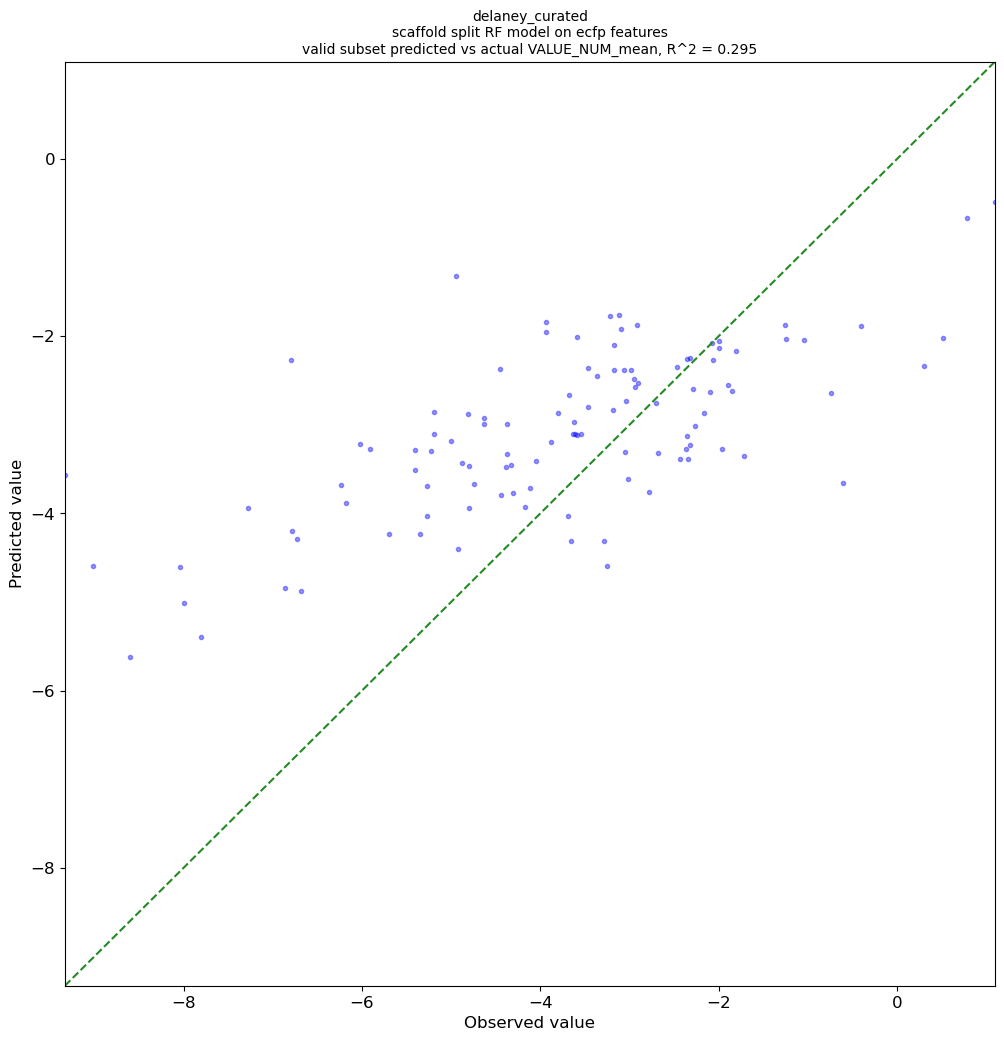

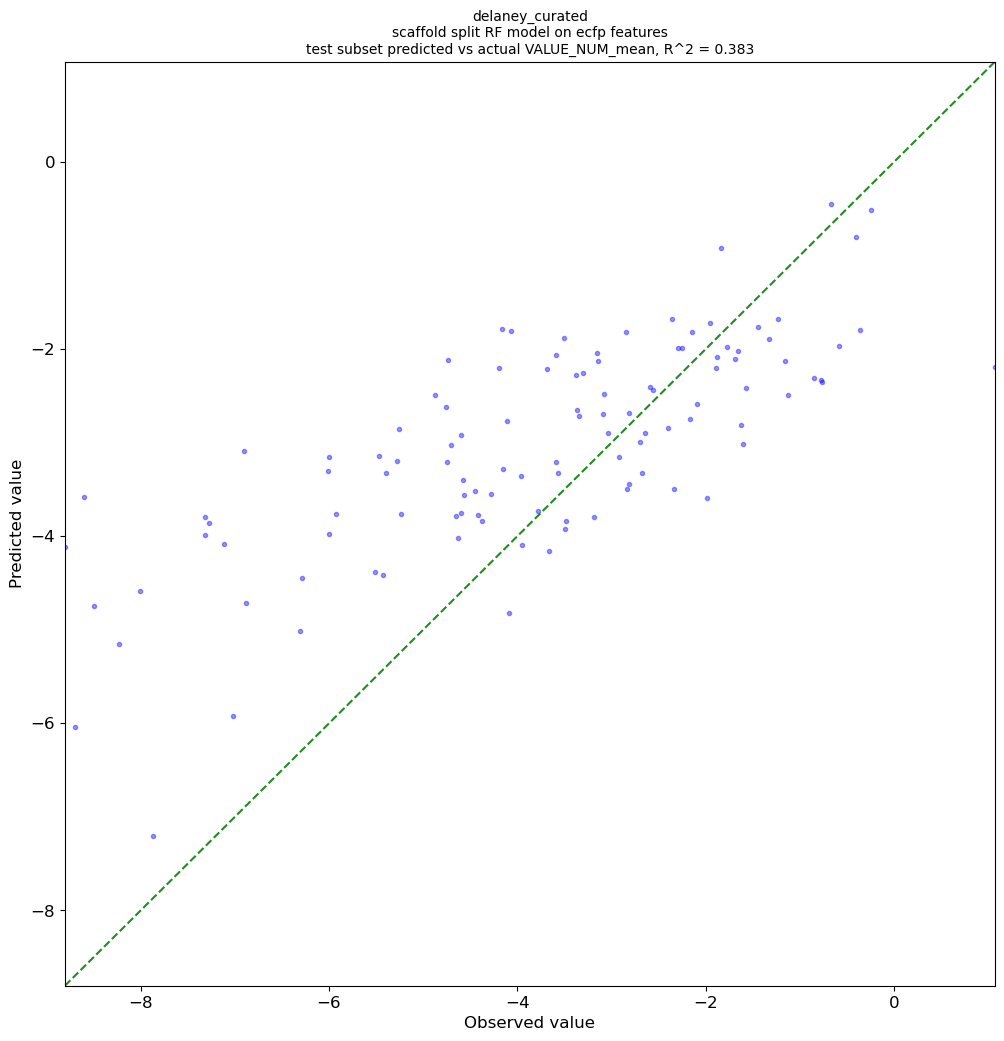

In [44]:


pp.plot_pred_vs_actual(MP)

In [45]:
pparams
# MP.train_model()

Namespace(bucket='public', dataset_key='/home/sagemaker-user/BigDataSys-Project8/delaney_curated.csv', dataset_name='delaney_curated', dataset_oid=None, datastore=False, id_col='compound_id', min_compound_number=200, response_cols=['VALUE_NUM_mean'], save_results=False, smiles_col='rdkit_smiles', max_dataset_rows=0, autoencoder_bucket=None, autoencoder_key=None, autoencoder_type='molvae', mol_vae_model_file=None, class_number=2, class_name=None, descriptor_bucket='public', descriptor_key=None, descriptor_oid=None, descriptor_spec_bucket='', descriptor_spec_key='/opt/conda/lib/python3.10/site-packages/atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv', descriptor_type='moe', moe_threads=-1, ecfp_radius=2, ecfp_size=1024, embedding_model_uuid=None, embedding_model_collection=None, embedding_model_path=None, featurizer='ecfp', model_choice_score_type='r2', model_type='RF', prediction_type='regression', previously_featurized=True, uncertainty=True, verbose=False, optimizer_type='a

In [46]:
!date

Mon Feb 26 23:52:51 UTC 2024
